In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
sns.set_theme(style='ticks')
import plotly.express as px
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

from g2aero.Grassmann import *
from g2aero.perturbation import PGAspace, Dataset

plot_folder = os.path.join(os.getcwd(), 'plots_pga_space', )
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
    

In [2]:
shapes_folder  = os.path.join(os.getcwd(), '../../data/airfoils_database/', )
airfoils = [
            'NACA64_A17', 
            'DU21_A17', 'DU25_A17', 'DU30_A17', 'DU35_A17', 'DU40_A17', 'DU00-W2-350',
            'FFA-W3-211',  'FFA-W3-241', 'FFA-W3-270blend', 'FFA-W3-301', 'FFA-W3-330blend', 'FFA-W3-360', 'SNL-FFA-W3-500',
            'S805A', 'S806A', 'S807', 'S809', 'S810', 'S812', 'S813', 'S816', 'S817', 'S820', 
            'S822', 'S823', 'S827', 'S828', 'S829', 'S830', 
            'S831', 'S832', 'S833', 'S834', 'S835']            

fam = ['NACA', 'DU', 'DU', 'DU', 'DU', 'DU','DU', 
      'FFA',  'FFA', 'FFA', 'FFA', 'FFA', 'FFA', 'FFA',
      'S','S','S','S','S','S','S','S','S','S', 
      'S','S','S','S','S','S','S','S','S','S',
      'S',]
gap_size = [0.0, 0.003878, 0.004262, 0.00492, 0.00566, 0.00694,  0.01,
            0.00131, 0.00751, 0.01265, 0.0182, 0.024079999999999997, 0.01368, 0.020200000000000003]

for i in range(30):
    gap_size.append(0.0)


families = [f for f in fam for i in range(1001)]
classes = [c for c in airfoils for i in range(1001)]
gap = np.array([g for g in gap_size for i in range(1001)])

n_airfoils = len(airfoils)
label_dict = dict(zip(airfoils, np.arange(n_airfoils)))
files = [shapes_folder + f'{af}.npz'for af in airfoils]
n_landmarks = 401
shapes = np.empty((0, n_landmarks, 2))
for i, file in enumerate(files):
    one_file_shapes = np.load(file)['shapes']
    shapes = np.vstack((shapes, one_file_shapes))
print(shapes.shape)   

# dict_color = {airfoils[i] : colors_pallete[i] for i in range(n_airfoils)}
# colors = np.array([dict_color[airfoil] for airfoil in airfoils for i in range(1001)])
# handles = [Line2D([0], [0], color='w', markerfacecolor=colors_pallete[i], marker='o', markersize=10, 
#                   label=airfoils[i]) for i in range(n_airfoils)]

(35035, 401, 2)


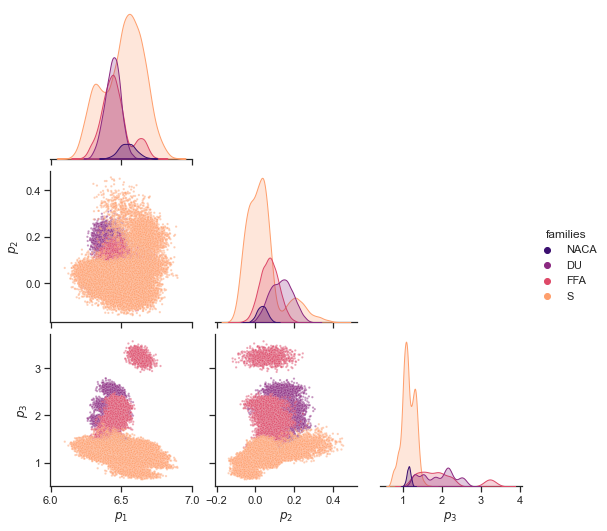

In [3]:
data = Dataset(shapes, method='SPD')
P = data.M.reshape(-1,4)[:, (0, 1, 3)]
df = pd.DataFrame(data=P, columns=['$p_1$', '$p_2$', '$p_3$'])
df.insert(3, "classes", classes)
df.insert(3, "families", families)
sns_plot = sns.pairplot(df, hue='families', x_vars=['$p_1$', '$p_2$', '$p_3$'], y_vars=['$p_1$', '$p_2$', '$p_3$'],
                        diag_kind='kde', palette="magma", corner=True, plot_kws=dict(alpha=.5, s=5))
fig = px.scatter_3d(df, x=r'$p_1$', y=r'$p_2$', z=r'$p_3$', color="families", 
                    color_discrete_sequence=px.colors.sequential.Magma)
fig.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
fig.show()
fig.write_html(os.path.join(plot_folder, '3d_SPD.html'))

In [4]:
# data = Dataset(shapes, method='LA-transform')
pga, t = PGAspace.create_from_dataset(shapes, n_modes=100)

Karcher mean convergence:
||V||_F = 0.032522300931844945
||V||_F = 4.1440744425122954e-05
||V||_F = 7.23032808177288e-08
||V||_F = 1.35167253862221e-10


(35035, 100)


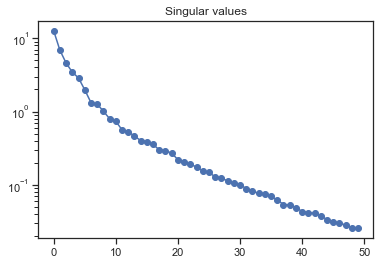

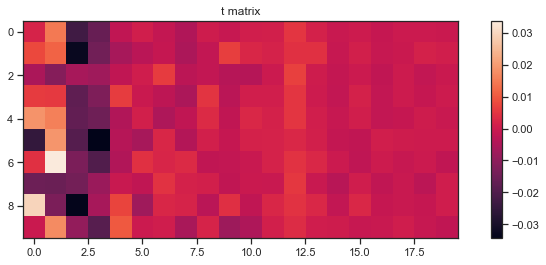

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogy(pga.S[:50], 'o-', color='b')
ax.set_title('Singular values')
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
cax = ax.imshow(t[:10, :20], interpolation='none')
fig.colorbar(cax)
ax.set_title('t matrix')
print(t.shape)

(35035,)


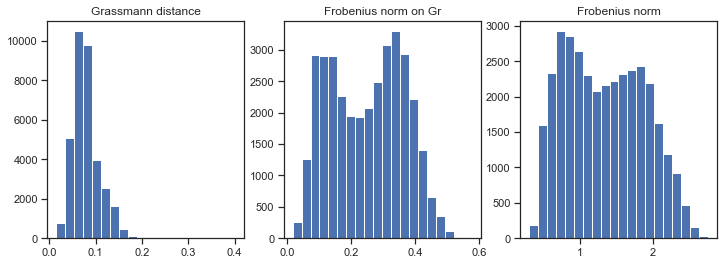

In [6]:
karcher_mean_phys = pga.karcher_mean @ pga.M_mean.T + pga.b_mean

dist_arr = np.empty(data.n_shapes)
dist_frob = np.empty(data.n_shapes)
dist_frob_gr = np.empty(data.n_shapes)
for i, shape in enumerate(data.shapes_gr):
    dist_arr[i] =  distance(pga.karcher_mean, shape)
    dist_frob_gr[i] =  np.linalg.norm(pga.karcher_mean - shape, 'fro')
    dist_frob[i] =  np.linalg.norm(karcher_mean_phys - shapes[i], 'fro')
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(dist_arr, bins=20)
ax[0].set_title('Grassmann distance')
ax[1].hist(dist_frob_gr, bins=20)
ax[1].set_title('Frobenius norm on Gr')
ax[2].hist(dist_frob, bins=20)
ax[2].set_title('Frobenius norm')
print(dist_arr.shape)

In [7]:
dist_gr = np.zeros((data.n_shapes, 19-2))
dist_fro = np.zeros((data.n_shapes, 19-2))
dist_phys = np.zeros((data.n_shapes, 19-2))
for i in range(2, 19):
    print(i)
    for j, coord in enumerate(t[:, :i]): 
        shape_new = perturb_gr_shape(pga.Vh[:i], pga.karcher_mean, coord)
        dist_gr[j, i-2] = distance(shape_new, data.shapes_gr[j])
        dist_fro[j, i-2] = np.linalg.norm(shape_new - data.shapes_gr[j], 'fro')
        phys_shape = shape_new @ data.M[j] + data.b[j]
        dist_phys[j, i-2] = np.linalg.norm(phys_shape - shapes[j], 'fro')
#         plt.plot(phys_shape[:, 0], phys_shape[:, 1], 'k')
#         plt.plot(shapes[j, :, 0], shapes[j, :, 1])
#         plt.show()
#         break

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


(2.0, 18.0)

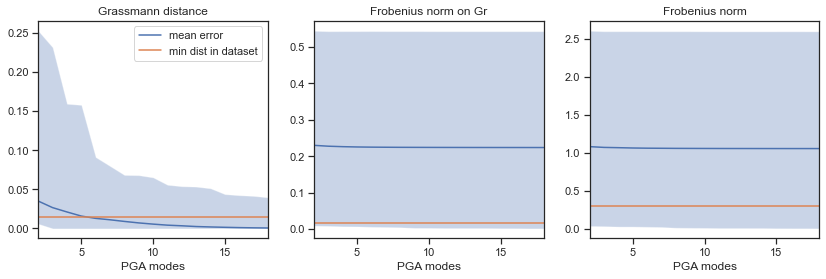

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex='row')
ax[0].plot(np.arange(2, 19), np.mean(dist_gr, axis=0), label='mean error')
ax[0].plot(np.arange(2, 19), np.min(dist_arr)*np.ones(17), label='min dist in dataset')
ax[0].fill_between(np.arange(2, 19), np.min(dist_gr, axis=0), np.max(dist_gr, axis=0), alpha=0.3)
ax[0].set_title('Grassmann distance')
ax[0].set_xlabel('PGA modes')
ax[0].legend()
ax[1].plot(np.arange(2, 19), np.mean(dist_fro, axis=0), label='mean error')
ax[1].plot(np.arange(2, 19), np.min(dist_frob_gr)*np.ones(17), label='min dist in dataset')
ax[1].fill_between(np.arange(2, 19),np.min(dist_fro, axis=0), np.max(dist_fro, axis=0), alpha=0.3)
ax[1].set_title('Frobenius norm on Gr')
ax[1].set_xlabel('PGA modes')
ax[2].plot(np.arange(2, 19), np.mean(dist_phys, axis=0), label='mean error')
ax[2].plot(np.arange(2, 19), np.min(dist_frob)*np.ones(17), label='min dist in dataset')
ax[2].fill_between(np.arange(2, 19),np.min(dist_phys, axis=0), np.max(dist_phys, axis=0), alpha=0.3)
ax[2].set_title('Frobenius norm')
ax[2].set_xlabel('PGA modes')
ax[2].set_xlim(2, 18)

In [9]:
coord = np.hstack((t[:, :4], data.M[:, 1:, 1], gap.reshape(-1, 1)))
print(t.shape)
df = pd.DataFrame(data=coord, columns=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'])
df.insert(5, "classes", classes)
df.insert(6, "families", families)
sns_plot = sns.pairplot(df, hue="classes",
                        x_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        y_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        diag_kind='kde', palette="magma", corner=True, plot_kws=dict(alpha=.5, s=5))
sns_plot.savefig(os.path.join(plot_folder, 'scatter_classes.png'))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 35035 and the array at index 2 has size 44044

In [ ]:
sns_plot = sns.pairplot(df, hue="families",
                        x_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        y_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        diag_kind='kde', palette="magma", corner=True, plot_kws=dict(alpha=.5, s=5))
sns_plot.savefig(os.path.join(plot_folder, 'scatter_families.png'))

In [ ]:
fig = px.scatter_3d(df, x=r'$t_1$', y=r'$t_2$', z=r'$t_3$', color="families")
fig.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
fig.show()
fig.write_html(os.path.join(plot_folder, '3d_families.html'))

In [ ]:
np.savez(os.path.join(os.getcwd(), '../../data/PGA_space/PGA_space.npz'), Vh=pga.Vh[:4], M_mean=pga.M_mean, b_mean=pga.b_mean, karcher_mean=pga.karcher_mean)
np.savez(os.path.join(os.getcwd(), '../../data/PGA_space/M_b.npz'), M=data.M, b=data.b)
np.savez(os.path.join(os.getcwd(), '../../data/PGA_space/t.npz'), t=t[:, :4])

In [ ]:
labels1 = ['DU00-W2-350', 'DU97-W-300', 'DU91-W2-250', 'DU08-W-210']
labels2 = ['DU35_A17', 'DU30_A17', 'DU25_A17', 'DU21_A17']
shapes_folder  = os.path.join(os.getcwd(), '../../data/airfoils_database/', )
files1 = [shapes_folder + f'{af}.npy'for af in labels1]
files2 = [shapes_folder + f'{af}.npy'for af in labels2]
shapes1 = np.empty((4, 401, 2))
shapes2 = np.empty((4, 401, 2))
for i in range(4):
    shapes1[i] = np.load(files1[i])[0]
    shapes2[i] = np.load(files2[i])[0]
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
for i, (xy1, xy2) in enumerate(zip(shapes1, shapes2)):
    ax[i//2, i%2].plot(xy2[:, 0], xy2[:, 1], label=labels2[i])
    ax[i//2, i%2].plot(xy1[:, 0], xy1[:, 1], label=labels1[i])
    ax[i//2, i%2].axis('equal')
    ax[i//2, i%2].legend(loc=0)
    ax[1, i%2].set_xlabel(r'$x^{loc}$', fontsize=15)
    ax[i//2, 0].set_ylabel(r'$y^{loc}$', fontsize=15)
fig.subplots_adjust(left=0.15, right=0.95,  bottom=0.12, top=0.98, )
fig.savefig(os.path.join(plot_folder, 'DU_compare.pdf'))